In [1]:
import os
import osi_pi
import pandas as pd
import datetime as dt
import numpy as np
from scipy import signal
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import matplotlib, matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns
import regex as re
import dplot.combine_pdfs
import warnings
warnings.filterwarnings('ignore')

folder_io = r'..\9. Input Data, Cache'
folder_plots_auto = r'..\3. Plots\auto'
df_tag_list = pd.read_csv(os.path.join(folder_io, 'tag_list.csv'))
list_tags_bw1 = df_tag_list.reset_index().Tagname.tolist()
list_tags_bw1 = list_tags_bw1 + ['BW.C.1.E90F010..XQ01_Avg']

# list_tags_bw4 = [re.sub(r'^BW.1*', 'BW.4', tag) for tag in df_tag_list.Tagname]

df_btf = pd.read_csv(os.path.join(folder_io, 'AGL_BTF_Register_RECORDS as at 22-09-16.csv'))
btf_time_bw1 = df_btf[df_btf['Unit']=='BW1']['BTF Date'].unique()[:7]
# btf_time_bw4 = df_btf[df_btf['Unit']=='BW4']['BTF Date'].unique()[:7]

In [2]:
df_1= osi_pi.df_from_pi_data(
    tag_names=list_tags_bw1,
    start='2019-01-01',
    end='2022-09-29',
    interval='1m',
    pi_method='interpolated',
    use_cache=True,
    split_query_freq='1w',
    n_threads=4
)
mics = [tag for tag in df_1.columns if 'M' in tag]


2022-10-14 11:39:06,402 - osi_pi_extractor_logger - WARNING - n_threads is currently limited to 2 on Corp-PI. Threads reduced from 4 to 2


100%|██████████| 8624/8624 [01:07<00:00, 127.24it/s]


<AxesSubplot:xlabel='timestamp'>

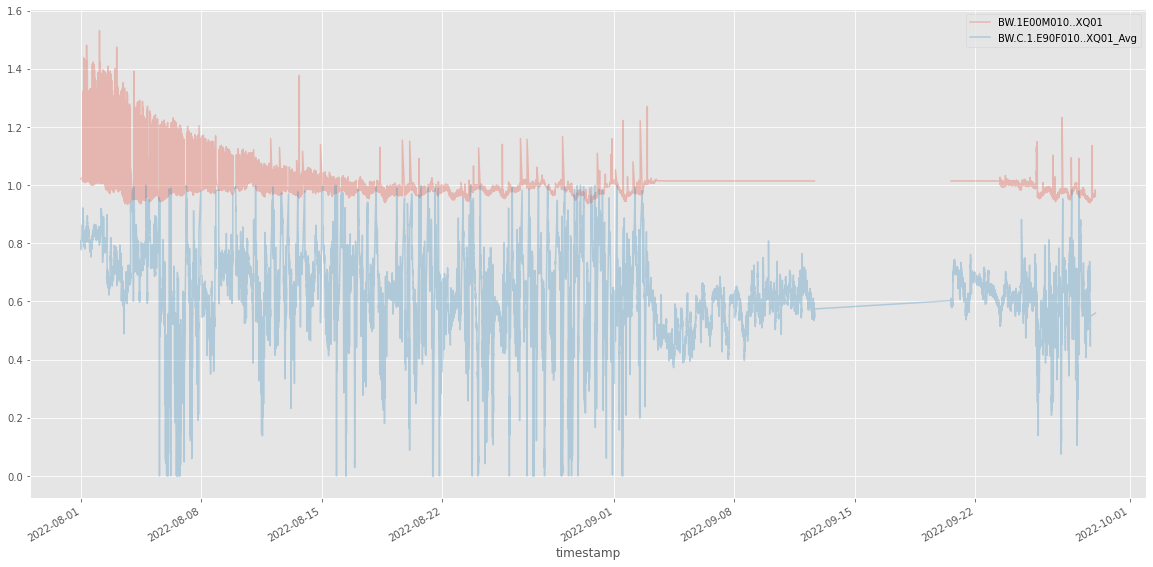

In [6]:
df_s = df_1[df_1['BW.C.1.E90F010..XQ01_Avg']<0.5]
df_s2 = df_s[['BW.1E00M010..XQ01', 'BW.C.1.E90F010..XQ01_Avg']]/[60,0.5]
start = '2022-08-01'
# fig, ax = plt.subplots(figsize=(20,10))
df_s2[start:].plot(figsize=(20,10),alpha=0.3)


In [7]:
# Normalisation is not required
df_s = df_1[df_1['BW.C.1.E90F010..XQ01_Avg']<0.5][mics]

# Moving mean analysis
short_window = 90
medium_window = 60*24*2
long_window = 60*24*7

tl_score = (df_s.rolling(short_window, min_periods=1).min().rolling(short_window, min_periods=1).median()-
            df_s.shift(medium_window).rolling(long_window, min_periods=1).median()).rolling(short_window, min_periods=1).median()

# this score calculates a score based on a moving median and mean of each microphones.
# tl_score = (df_s.rolling(short_window, min_periods=1).min().rolling(short_window, min_periods=1).median()-
#             df_s.shift(medium_window).rolling(long_window, min_periods=1).median()).rolling(short_window, min_periods=1).median()

In [8]:
# tl_score_4 = (df_4.rolling(short_window, min_periods=1).min().rolling(short_window, min_periods=1).median()-
#             df_4.shift(medium_window).rolling(long_window, min_periods=1).median()).rolling(short_window, min_periods=1).median()

In [9]:
import matplotlib as mpl

def create_colormap():
    cmap = mpl.colors.ListedColormap(['white', 'red'])
    cmap.set_over('0.25')
    cmap.set_under('0.75')
    bounds = [0,1]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    return cmap, norm
    
def plot_events(df, ax):
    ax.plot(df.iloc[:,0])
    ax.set_xlim([df.index[0], df.index[-1]])
    cmap, norm = create_colormap()
    ax.pcolorfast(ax.get_xlim(), ax.get_ylim(), df.iloc[:,1].values[np.newaxis], cmap=cmap, alpha=0.3)
    ax.set_ylabel('Tube leak score')


In [11]:

i=1000
for mic in mics:
    for btime in btf_time_bw1:
        # Plotting
        start=dt.datetime.strptime(btime, '%d/%m/%Y') - dt.timedelta(days=30),
        end=dt.datetime.strptime(btime, '%d/%m/%Y') + dt.timedelta(days=5),
        fig, ax = plt.subplots(2,1,figsize=(20,10))
        mic_series = tl_score[mic][start[0].strftime("%Y-%m-%d"): end[0].strftime("%Y-%m-%d")]
        mic_over_1 = (mic_series>6)*1
        df_to_plot = pd.concat([mic_series,mic_over_1], axis=1)
        plot_events(df_to_plot,ax[1])
        ax[0].plot(df_s[mic][start[0].strftime("%Y-%m-%d"): end[0].strftime("%Y-%m-%d")], alpha=0.3)
        ax[0].plot(df_s[mic][start[0].strftime("%Y-%m-%d"): end[0].strftime("%Y-%m-%d")].rolling(25).median(), 'g')
        ax[0].set_title('Tube leak score for: {}'.format(osi_pi.get_descriptions_of_pi_points(mic)[0]))
        ax[0].axvline(dt.datetime.strptime(btime, '%d/%m/%Y'), color="green", linestyle="dashed")
        ax[0].set_xlim(start[0], end[0])
        ax[1].plot(mic_series, 'b')
        ax[1].axvline(dt.datetime.strptime(btime, '%d/%m/%Y'), color="green", linestyle="dashed")
        ax[1].set_xlabel('Time')
        ax[1].set_xlim(start[0], end[0])
        i += 1
        plot_counter = f'1 {i}'
        fig.savefig(
                os.path.join(folder_plots_auto, 
                '{}.pdf'.format(plot_counter)),
                dpi=200,
                bbox_inches='tight'
            )
        plt.close()

        
fname_pdf_report = '1 {}-{}-{} {} {} tube failures median analysis_BW1.pdf'.format(
        dt.datetime.now().year,dt.datetime.now().month,dt.datetime.now().day,dt.datetime.now().hour,dt.datetime.now().minute)

dplot.combine_pdfs.combine_pdfs_in_folder(
    folder_plots_auto, output_file=os.path.join(r'..\5. Slides and reports', fname_pdf_report))

import os, shutil
folder = folder_plots_auto
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))